The NHS 10 year plan comits the NHS to shifting from MDI to DPI. This notebook seeks to describe the trends and variation and model the cost of such a policy on the medicines budget

In [1]:
### here we import various libraries needed
import pandas as pd
import numpy as np
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import verbose
#verbose.level = 'helpful'      # one of silent, helpful, debug, debug-annoying

# taken from https://github.com/jrmontag/STLDecompose
# requires installation - pip install stldecompose
from stldecompose import decompose
# Simpler smoothing uses:
# from statsmodels.tsa.seasonal import seasonal_decompose

import geopandas as gpd


In [2]:
## Here we query our prescribing file to create a dataframe of all inhaler prescribing
sql = '''
SELECT
  pct,
  pract.name,
  presc.practice,
  AVG(total_list_size) AS list_size,
  presc.month,
  SUM(IF(form_route='powderinhalation.inhalation', ##from dmd, identifies a DPI 
      items,
      0)) AS dpi,
      SUM(IF(form_route='pressurizedinhalation.inhalation',  ##from dmd, identifies a MDI
      items,
      0)) AS mdi,
      SUM(items) AS totalinhalers,
    SUM(actual_cost) AS totalcost
   FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc
LEFT JOIN
  ebmdatalab.hscic.practices AS pract
ON
  presc.practice=pract.code
  LEFT JOIN  # is this join in the right place  review
  ebmdatalab.hscic.practice_statistics_all_years AS stat
ON
  presc.practice = stat.practice
  AND presc.month = stat.month
LEFT JOIN
  ebmdatalab.dmd.form_dose AS dmd
ON
  presc.bnf_code=dmd.bnf_code
WHERE
  presc.bnf_code LIKE "030%"
  AND pract.setting=4 ## I have restricted to "normal" general practice. Review choice with team
AND (form_route="powderinhalation.inhalation"
    OR form_route= "pressurizedinhalation.inhalation")
GROUP BY
  pct,
  name,
  practice,  
  month
  '''


df_inhaler = bq.cached_read(sql, csv_path='df_inhaler.csv', use_cache=True)  # add `use_cache=False` to override
df_inhaler['month'] = df_inhaler['month'].astype('datetime64[ns]')
df_inhaler.head()

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,pct,name,practice,list_size,month,dpi,mdi,totalinhalers,totalcost
0,08G,HAREFIELD PRACTICE,E86007,9451.0,2015-08-01,282,612,894,19989.08
1,09H,COACHMANS MEDICAL PRACTICE,H82098,10288.0,2015-08-01,161,325,486,18116.86
2,02E,DALLAM LANE MEDICAL CENTRE,N81097,2861.0,2015-08-01,211,275,486,13047.92
3,15D,LANGLEY HEALTH CENTRE,K81024,17262.0,2015-08-01,398,827,1225,26973.58
4,14L,HAZELDENE MEDICAL CENTRE,P84067,6591.0,2015-08-01,282,344,626,13283.72


In [3]:
# here we calculate current proportion of inhalers prescribed as DPI
df_inhaler["per_dpi"] = 100*(df_inhaler.dpi/(df_inhaler.dpi+df_inhaler.mdi)).fillna(0)

df_inhaler.head()

,pct,name,practice,list_size,month,dpi,mdi,totalinhalers,totalcost,per_dpi
0,08G,HAREFIELD PRACTICE,E86007,9451.0,2015-08-01,282,612,894,19989.08,31.543624
1,09H,COACHMANS MEDICAL PRACTICE,H82098,10288.0,2015-08-01,161,325,486,18116.86,33.127572
2,02E,DALLAM LANE MEDICAL CENTRE,N81097,2861.0,2015-08-01,211,275,486,13047.92,43.415638
3,15D,LANGLEY HEALTH CENTRE,K81024,17262.0,2015-08-01,398,827,1225,26973.58,32.489796
4,14L,HAZELDENE MEDICAL CENTRE,P84067,6591.0,2015-08-01,282,344,626,13283.72,45.047923


In [4]:
# here I repeated this...........this isproblem when doing in snatched time and big gaps in between!
pc = df_inhaler.copy()
pc["percentage_dpi"] = 100*(pc.dpi/(pc.dpi+pc.mdi)).fillna(0)
pc.head()

,pct,name,practice,list_size,month,dpi,mdi,totalinhalers,totalcost,per_dpi,percentage_dpi
0,08G,HAREFIELD PRACTICE,E86007,9451.0,2015-08-01,282,612,894,19989.08,31.543624,31.543624
1,09H,COACHMANS MEDICAL PRACTICE,H82098,10288.0,2015-08-01,161,325,486,18116.86,33.127572,33.127572
2,02E,DALLAM LANE MEDICAL CENTRE,N81097,2861.0,2015-08-01,211,275,486,13047.92,43.415638,43.415638
3,15D,LANGLEY HEALTH CENTRE,K81024,17262.0,2015-08-01,398,827,1225,26973.58,32.489796,32.489796
4,14L,HAZELDENE MEDICAL CENTRE,P84067,6591.0,2015-08-01,282,344,626,13283.72,45.047923,45.047923


In [5]:
pc.practice.drop_duplicates().count()

8172

In [6]:
# filter for "normal" practices
filtered = df_inhaler.copy().loc[(df_inhaler.list_size>1000) & (df_inhaler["month"]>"2010-09-01") ]  
filtered.head()

#deciles,perecentiles etc.

x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))

#filtered tables grouped by months
pcf = filtered.groupby('month').quantile(x)

#putting groupby(month) from index back into being a column
pcf = pcf.reset_index().rename(columns={"level_1": 'percentile'})
pcf.head(5)

,month,percentile,list_size,dpi,mdi,totalinhalers,totalcost,per_dpi
0,2010-10-01,0.1,2377.5,39.0,111.0,162.0,3669.93,17.044889
1,2010-10-01,0.2,3185.0,59.0,159.0,230.0,5354.58,20.841683
2,2010-10-01,0.3,4063.0,79.0,207.0,296.0,7146.93,23.560455
3,2010-10-01,0.4,5044.0,101.0,260.0,372.0,9075.16,26.086957
4,2010-10-01,0.5,6082.0,126.0,318.0,457.0,11238.55,28.571429


In [7]:
filtered.practice.drop_duplicates().count()

8056

## Current trends in prescribing

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


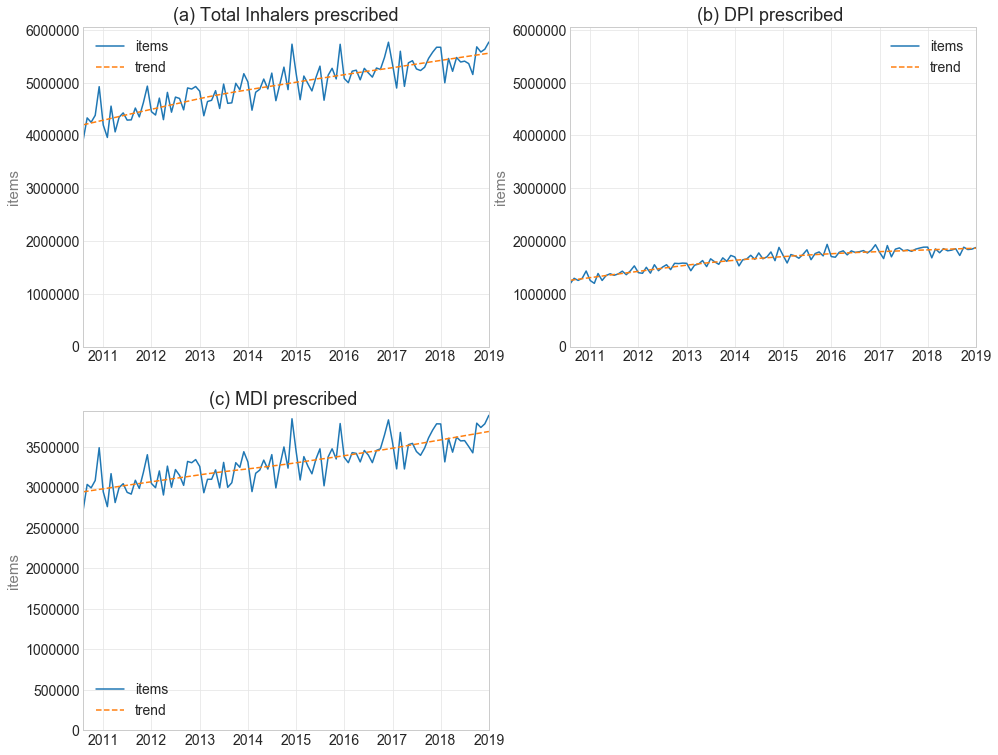

In [8]:
# here we code for plots of current prescribing trends over time

sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = df_inhaler.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
data = df_inhaler.groupby('month').sum()[['totalinhalers','list_size']]
data = pd.DataFrame(data['totalinhalers'])
data["totalinhalers"] = data["totalinhalers"]

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))#/data)*100

#total inhalers
ax = plt.subplot(gs[0,0])
ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('items', size =15, alpha=0.6)
ax.set_title('(a) Total Inhalers prescribed',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
max_value = data["totalinhalers"].max()*1.05
ax.set_ylim([0,max_value])
ax.legend(prop={'size': 14})


#total DPI inahlers
ax = plt.subplot(gs[0,1])
data = df_inhaler.groupby('month').sum()[['dpi', 'list_size']]
data = pd.DataFrame(data['dpi'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('items', size =15, alpha=0.6)
ax.set_title('(b) DPI prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,max_value])
ax.legend(prop={'size': 14})


#MDI Inhalers
ax = plt.subplot(gs[1,0])
data = df_inhaler.groupby('month').sum()[['mdi','list_size']]
data = pd.DataFrame(data['mdi'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('items', size =15, alpha=0.6)
ax.set_title('(c) MDI prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim(ymin=0)
ax.legend(prop={'size': 14})

plt.show()

# Practice Deciles of DPI Usage

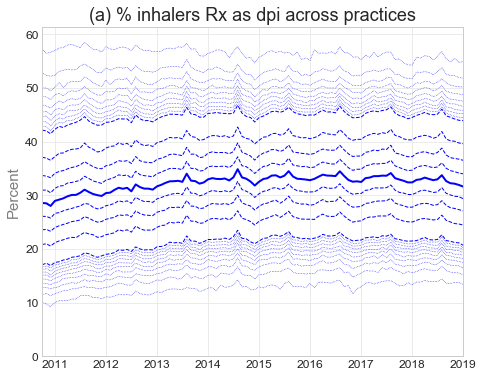

In [9]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.copy().sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
# order is column, title, axis
s = [(0,'per_dpi',0,0,'(a) % inhalers Rx as dpi across practices','Percent'),]


x = pd.Series(x)
fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    ax.set_ylabel(i[5], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_no_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show() 

In [10]:
pcf.head()

,month,percentile,list_size,dpi,mdi,totalinhalers,totalcost,per_dpi
0,2010-10-01,0.1,2377.5,39.0,111.0,162.0,3669.93,17.044889
1,2010-10-01,0.2,3185.0,59.0,159.0,230.0,5354.58,20.841683
2,2010-10-01,0.3,4063.0,79.0,207.0,296.0,7146.93,23.560455
3,2010-10-01,0.4,5044.0,101.0,260.0,372.0,9075.16,26.086957
4,2010-10-01,0.5,6082.0,126.0,318.0,457.0,11238.55,28.571429


### Maps for 2018

In [11]:
#aggregate over 2018
ccg_last_year = df_inhaler.groupby(['pct','month'],as_index=False).sum()
ccg_last_year = ccg_last_year.loc[(ccg_last_year["month"]>="2018-01-01") & (ccg_last_year["month"]<="2018-12-01")]

#ccg_last_year = all_inhalers_ccg.loc[all_inhalers_ccg.month]
ccg_last_year = ccg_last_year.groupby('pct').sum()
ccg_last_year["list_size"] = ccg_last_year["list_size"]/12

df_inhaler["per_dpi"] = 100*(df_inhaler.dpi/(df_inhaler.dpi+df_inhaler.mdi)).fillna(0)
df_inhaler["costperinh"] = (df_inhaler.totalcost/df_inhaler.totalinhalers).fillna(0)

ccg_last_year["per_dpi"] = 100*(ccg_last_year.dpi/(ccg_last_year.dpi+ccg_last_year.mdi)).fillna(0)


ccg_last_year.head()

,list_size,dpi,mdi,totalinhalers,totalcost,per_dpi
pct,,,,,,
00C,108423.333333,59512,79716,139228,3.225843e+06,42.744276
00D,292336.000000,214374,318714,533088,1.055665e+07,40.213623
00J,259779.833333,142697,214216,356913,7.234600e+06,39.980892
00K,297508.166667,183599,292695,476294,1.008895e+07,38.547410
00L,325704.916667,221296,246766,468062,1.021240e+07,47.279207


In [12]:
sql='''
SELECT
  DISTINCT code,
  name
FROM
  ebmdatalab.hscic.ccgs
WHERE
  name IS NOT NULL'''

names = bq.cached_read(sql, csv_path='names.csv', use_cache=True)
names.head(5)

,code,name
0,00T,NHS BOLTON CCG
1,14C,WEST MIDLANDS COMMISSIONING HUB
2,05N,NHS SHROPSHIRE CCG
3,01E,NHS GREATER PRESTON CCG
4,11H,NHS BRISTOL CCG


In [13]:
# join to geographical data
map_data = ccg_last_year.reset_index()
names = names.rename(columns={"CCG17CDH":"code","CCG17NM":"name"})
map_data = map_data.merge(names[['code','name']],left_on="pct",right_on="code")
map_data['name'] = map_data['name'].str.upper()
map_data['name'] = map_data["name"].str.replace("&","AND")
map_data = map_data.set_index('name')
#map_data = map_data.round(0)
map_data.head() 

,pct,list_size,dpi,mdi,totalinhalers,totalcost,per_dpi,code
name,,,,,,,,
NHS DARLINGTON CCG,00C,108423.333333,59512,79716,139228,3.225843e+06,42.744276,00C
"NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG",00D,292336.000000,214374,318714,533088,1.055665e+07,40.213623,00D
NHS NORTH DURHAM CCG,00J,259779.833333,142697,214216,356913,7.234600e+06,39.980892,00J
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,00K,297508.166667,183599,292695,476294,1.008895e+07,38.547410,00K
NHS NORTHUMBERLAND CCG,00L,325704.916667,221296,246766,468062,1.021240e+07,47.279207,00L


In [14]:
from urllib.request import urlopen
from urllib.request import Request
import json
url = "https://openprescribing.net/api/1.0/org_location/?org_type=ccg"
hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}
req = Request(url, headers=hdr)
page = urlopen(req)
json_file = json.loads(page.read().decode())
with open('ccgs.json', 'w') as outfile:
    json.dump(json_file, outfile)

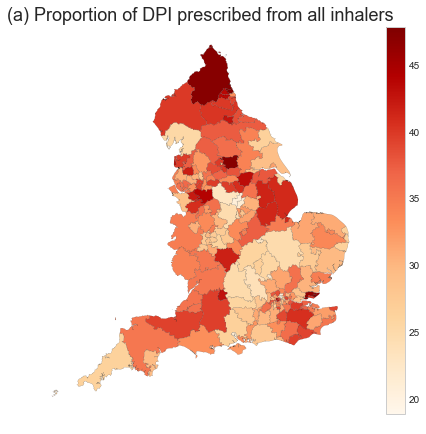

In [15]:
# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf = ccgs.join(map_data)

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,"per_dpi",0,0,'(a) Proportion of DPI prescribed from all inhalers'),]     

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[4],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.07)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

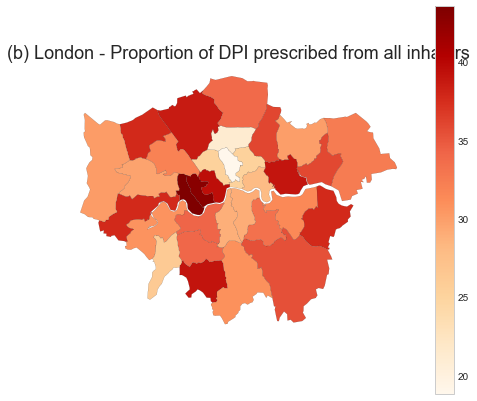

In [16]:
plt.show()# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf = ccgs.join(map_data)
gdf = gdf.loc[(gdf["pct"]=="08H") 
              | (gdf["pct"]=="07L")
              | (gdf["pct"]=="07M")
              | (gdf["pct"]=="07N")
              | (gdf["pct"]=="8M")
              | (gdf["pct"]=="07P")
              | (gdf["pct"]=="07Q")
              | (gdf["pct"]=="07R")
              | (gdf["pct"]=="09A")
              | (gdf["pct"]=="07T")
              | (gdf["pct"]=="07V")
              | (gdf["pct"]=="07X")
              | (gdf["pct"]=="07W")
              | (gdf["pct"]=="08A")
              | (gdf["pct"]=="08C")
              | (gdf["pct"]=="08D")
              | (gdf["pct"]=="08E")
              | (gdf["pct"]=="08F")
              | (gdf["pct"]=="08G")
              | (gdf["pct"]=="07Y")
              | (gdf["pct"]=="08J")
              | (gdf["pct"]=="08K")
              | (gdf["pct"]=="08L")
              | (gdf["pct"]=="08R")
              | (gdf["pct"]=="08Q")
              | (gdf["pct"]=="08T")
              | (gdf["pct"]=="08V")
              | (gdf["pct"]=="08W")
              | (gdf["pct"]=="08X")
              | (gdf["pct"]=="08Y")
              | (gdf["pct"]=="08M")
              | (gdf["pct"]=="08N")
              | (gdf["pct"]=="08P")
              ]             
            #zoom in London

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,"per_dpi",0,0,'(b) London - Proportion of DPI prescribed from all inhalers'),]  

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[4],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.07)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

## Inhalers Matching

In [17]:
## here we importat a file where all generics have been matched
genericmatchedinhalers = pd.read_csv(r'C:\Users\bmackenna\Documents\GitHub\jupyter-notebooks\environmental_impact_inhalers\genericinhalersmatch.csv')
genericmatchedinhalers.head(5)

,bnf_code,presentation,form_route,chemical,match_bnf_code,match_presentation
0,0302000C0AABFBF,Beclomet Diprop_Inha 100mcg (200 D) CFF,pressurizedinhalation.inhalation,Beclometasone Dipropionate,0302000C0AABJBJ,Beclomet Diprop_Pdr For Inh 100mcg(200 D
1,0302000C0AAABAB,Beclomet Diprop_Inha 100mcg (200D),pressurizedinhalation.inhalation,Beclometasone Dipropionate,0302000C0AABJBJ,Beclomet Diprop_Pdr For Inh 100mcg(200 D
2,0302000C0AABVBV,Beclomet Diprop_Inha 200mcg (200 D) CFF,pressurizedinhalation.inhalation,Beclometasone Dipropionate,0302000C0AABUBU,Beclomet Diprop_Pdr For Inh 200mcg(200D)
3,0302000C0AAARAR,Beclomet Diprop_Inha 200mcg (200D),pressurizedinhalation.inhalation,Beclometasone Dipropionate,0302000C0AABUBU,Beclomet Diprop_Pdr For Inh 200mcg(200D)
4,0302000C0AABWBW,Beclomet Diprop_Inha 250mcg (200 D) CFF,pressurizedinhalation.inhalation,Beclometasone Dipropionate,0302000C0AABKBK,Beclomet Diprop_Pdr For Inh 250mcg(100 D


In [18]:
sql = '''
SELECT
  rx.bnf_name,
  rx.bnf_code,
  SUM(quantity) AS quantity,
  SUM(net_cost) AS net_cost, -- we use net cost as this is what PPU figure is. Also average discount needs to be applied which varies month on month
  match_bnf_code,
  ppu.median_price_per_unit, --this is from the median price per unit view, gives the PPU as per Jan 2019 for generic DPI equivalent
  SUM(quantity)*ppu.median_price_per_unit AS dpi_cost, --this calculates the new DPI equivalent actual cost
  (SUM(quantity)*ppu.median_price_per_unit)-SUM(rx.actual_cost) AS difference --calculates the difference between the two
FROM
  `brian.inhalers_dpi_equiv` AS inh --the match table which is the file in above cell but now uploaded to BigQuery
JOIN
  `hscic.normalised_prescribing_standard_latest_month` AS rx
ON
  CONCAT(SUBSTR(rx.bnf_code,0,9),(SUBSTR(rx.bnf_code,-2,2))) = CONCAT(SUBSTR(inh.bnf_code,0,9),(SUBSTR(inh.bnf_code,-2,2))) --joins all brands and generic to generic in match table
LEFT JOIN 
(SELECT * FROM `measures.vw__median_price_per_unit` WHERE date = '2019-01-01') AS ppu --joins to median PPU table, specifying PPU only for January 2019
ON
  inh.match_bnf_code = ppu.bnf_code
GROUP BY
  bnf_name,
  bnf_code,
  match_bnf_code,
  ppu.median_price_per_unit
ORDER BY
  bnf_code'''

df_inhaler_matching = bq.cached_read(sql, csv_path='df_inhaler_matching.csv', use_cache=True)  # add `use_cache=False` to override

df_inhaler_matching.head

,bnf_name,bnf_code,quantity,net_cost,match_bnf_code,median_price_per_unit,dpi_cost,difference
0,Formoterol Fumar_Inh 12mcg (100D) CFF,0301011E0AAADAD,2269,68206.14,0301011E0AAACAC,24.80,56271.20,-7.058204e+03
1,Atimos Modulite_Inh 12mcg (100D),0301011E0BDAAAD,1303,39168.18,0301011E0AAACAC,24.80,32314.40,-4.051484e+03
2,Salbutamol_Inha 100mcg (200 D),0301011R0AAAAAA,126,195.59,0301011R0AABZBZ,3.31,417.06,2.342341e+02
3,Salbutamol_Inha 100mcg (200 D) CFF,0301011R0AAAPAP,1408396,2112591.96,0301011R0AABZBZ,3.31,4661790.76,2.687985e+06
4,Salbutamol_Inha B/A 100mcg (200 D) CFF,0301011R0AABUBU,86686,546121.40,0301011R0AABZBZ,3.31,286930.66,-2.208004e+05


In [19]:
impact_Jan = df_inhaler_matching['difference'].sum()
impact_Jan

3969086.015406587

In [20]:
impact_per_annum = impact_Jan*12*0.9281 ## national ave discount in Jan =7.19
impact_per_annum

44204504.77078625

In [21]:
df_inhaler_matching.head(50)

,bnf_name,bnf_code,quantity,net_cost,match_bnf_code,median_price_per_unit,dpi_cost,difference
0,Formoterol Fumar_Inh 12mcg (100D) CFF,0301011E0AAADAD,2269,68206.14,0301011E0AAACAC,24.800000,5.627120e+04,-7.058204e+03
1,Atimos Modulite_Inh 12mcg (100D),0301011E0BDAAAD,1303,39168.18,0301011E0AAACAC,24.800000,3.231440e+04,-4.051484e+03
2,Salbutamol_Inha 100mcg (200 D),0301011R0AAAAAA,126,195.59,0301011R0AABZBZ,3.310000,4.170600e+02,2.342341e+02
3,Salbutamol_Inha 100mcg (200 D) CFF,0301011R0AAAPAP,1408396,2112591.96,0301011R0AABZBZ,3.310000,4.661791e+06,2.687985e+06
4,Salbutamol_Inha B/A 100mcg (200 D) CFF,0301011R0AABUBU,86686,546121.40,0301011R0AABZBZ,3.310000,2.869307e+05,-2.208004e+05
5,Ventolin_Evohaler 100mcg (200 D),0301011R0BEAIAP,748239,1122357.70,0301011R0AABZBZ,3.310000,2.476671e+06,1.428304e+06
6,Salamol_Inha 100mcg (200 D) CFF (Teva),0301011R0BIAFAP,44018,64266.10,0301011R0AABZBZ,3.310000,1.456996e+05,8.564057e+04
7,Salamol E-Breathe_Inh 100mcg (200 D) CFF,0301011R0BIAGBU,42310,266552.84,0301011R0AABZBZ,3.310000,1.400461e+05,-1.077448e+05
8,Salamol_Inha 100mcg (200 D) CFF (Arrow),0301011R0BIAHAP,2,5.66,0301011R0AABZBZ,3.310000,6.620000e+00,1.341880e+00
9,Airomir_Inha 100mcg (200 D),0301011R0BMAAAP,2321,4572.37,0301011R0AABZBZ,3.310000,7.682510e+03,3.417881e+03


Now we need to count the coverage of DPI after matching and full switch.

Logic where the match_bnf_code is blank we need to sum the quantity column and divide by total.